# NIH-Chest X-Ray Classification
This notebook attempts to use the given Chest X-ray dataset to demonstrate binary and multilabel classification.
1. We will first create a [dataset parser](#Parser) for exploration and visualization.
2. We will attempt [binary classification](#Binary) on the given dataset.
3. We will attempt [multilabel classification](#Multilabel) on the given dataset and will also resolve the class imbalance issue to certain extent.

In [1]:
import numpy as np 
import pandas as pd 
import glob
import matplotlib.pyplot as plt
import random
import math
import cv2
import os
import warnings

warnings.filterwarnings('ignore')

#from tensorflow.keras.layers import ... 

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model

<div id="Parser"></div>

# Creating a Dataset Parser

First let's create a dataset parser which will help us in visualizing images from the dataset, exploring class imbalance and creating the labels dataframe to be used for classification. This parser will also be used to sample datapoints (weighted based on the number of classes) when imbalance is detected. We shall use the same parser class for both binary and multilabel classification, which can be set using the `task_type` parameter.

In [2]:
class DatasetParser():
    def __init__(self, root_dir, images_dir, labels_csv, task_type="binary"):
        
        '''
        parameters:
                    root_dir: The path to root directory which contains a labels csv file and images_dir
                    images_dir: The name of the directory containing the images
                    labels_csv: The name of the csv containing information of the labels
                    task_type: Either binary or multiclass
        '''
        
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, images_dir,"*.png")))
        self.labels_df = self._labels_by_task(task_type=task_type, root_dir=root_dir, labels_csv=labels_csv)
        self.task_type = task_type
        
        if task_type is "binary":
            self.labels = ['normal', 'abnormal']
        else:
            self.labels = ['Cardiomegaly','Emphysema','Effusion',
                           'Hernia','Nodule','Pneumothorax','Atelectasis',
                           'Pleural_Thickening','Mass','Edema','Consolidation',
                           'Infiltration','Fibrosis','Pneumonia', 'No Finding']
        
    def visualize_random_images(self, num_images=1, label=None, display_label=False):
        
        '''
        parameters:
                    num_images: The number of images to display
                    label: If none then random images will be displayed.
                           Else, display images with a particular label
                    display_label: Decides if the label needs to be displayed
        '''
        
        fig = plt.figure(figsize=(20,20))
        fig.tight_layout(pad=10.0)
        if label is None:
            idxs = random.sample(range(len(self.image_paths)), num_images)
        else:
            idxs = [idx for idx in range(len(self.labels_df['Label'])) if label in self.labels_df['Label'][idx]]
            if len(idxs) < num_images:
                num_images = len(idxs)
            else:
                idxs = random.sample(idxs, num_images)
                
        num_rows = math.ceil(np.sqrt(num_images))
        num_cols = math.ceil(num_images/num_rows)
        
        for i in range(num_images):
            img = cv2.imread(self.image_paths[idxs[i]])
            plt.subplot(num_rows, num_cols, i+1)
            if display_label:
                plt.gca().set_title(self.labels_df['Label'][idxs[i]],wrap=True)
            plt.axis('off')
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            
    def _labels_by_task(self,task_type="binary", root_dir=None, labels_csv=None):
        '''
            Helper method for modifying the labels dataframe with respect to the required task.
            
            Returns: New labels dataframe with columns ('Id', 'Labels') 
        '''
        
        labels_df = pd.read_csv(os.path.join(root_dir, labels_csv))
        new_labels_df = pd.DataFrame()
        new_labels_df['Id'] = labels_df['Image Index'].copy()
        
        if task_type is "binary":
            new_labels_df.loc[labels_df['Finding Labels'] == "No Finding",'Label'] = "normal"
            new_labels_df.loc[labels_df['Finding Labels'] != "No Finding", 'Label'] = "abnormal"
        else:
            new_labels_df['Label'] = labels_df['Finding Labels'].apply(lambda val: val.split('|'))
        
        del labels_df
        
        return new_labels_df
    
    def explore_class_imbalance(self):
        '''
            Returns a plot of class frequencies along with an indication of class imbalance
        '''
        label_counts = [0 for i in range(len(self.labels))]
        
        for label in self.labels_df['Label']:
            if self.task_type == "binary":
                label_counts[self.labels.index(label)] += 1
            else:
                for element in label:
                    label_counts[self.labels.index(element)] += 1
        
        fig, ax1 = plt.subplots(1,1,figsize = (6, 6))
        ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
        ax1.set_xticks(np.arange(len(label_counts))+0.5)
        _ = ax1.set_xticklabels(self.labels, rotation = 90)
        
        for i,label in enumerate(self.labels):
            print(label, ':', label_counts[i])
            
        if(min(label_counts) < np.sqrt(max(label_counts))):
            print("Imbalance detected")
        else:
            print("Imbalance not detected")
            
    def get_labels_df(self):
        '''
            Returns dataframe with one-hot encoded or multi-hot encoded labels. 
        '''
        new_labels_df = self.labels_df.copy()
        
        if self.task_type is "binary":
            new_labels_df.loc[self.labels_df['Label'] == "normal",'Label'] = str(0)
            new_labels_df.loc[self.labels_df['Label'] != "normal", 'Label'] = str(1)
        else:
            for i in range(len(new_labels_df)):
                one_hot = [0 for element in self.labels]
                for element in new_labels_df['Label'][i]:
                    one_hot[self.labels.index(element)] = 1
                new_labels_df['Label'][i] = one_hot
                
        return new_labels_df
    
    def sample(self, num_samples, is_weighted=False):
        '''
        Parameters:
                    num_samples: number of samples to be returned
                    is_weighted: if True, then the samples are weighted wrt the number of classes
                                 represented by that sample
                                
        Returns: Dataframe with the required number of samples
        '''
        if not is_weighted:
            return self.labels_df.sample(num_samples)
        else:
            sample_weights = self.labels_df['Label'].map(lambda x: len(x)).values + 4e-2
            sample_weights /= sample_weights.sum()
            return self.labels_df.sample(num_samples, weights=sample_weights)

<div id="Binary"></div>

# Binary classification
We now create a parser for binary classification as an instance of `DatasetParser`. We set the `task_type` parameter to "binary" for binary classification.

In [3]:
parser = DatasetParser(root_dir="C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/",
                       images_dir="sample/images",
                       labels_csv="sample_labels.csv",
                       task_type="binary"
                      )

## Visualization and Exploration
Let's visualize a few random images from the dataset using the `visualize_random_images` method. Labels can also be specified using the `label` parameter if images from that particular class need to be visualized. For now let's observe 25 random images.

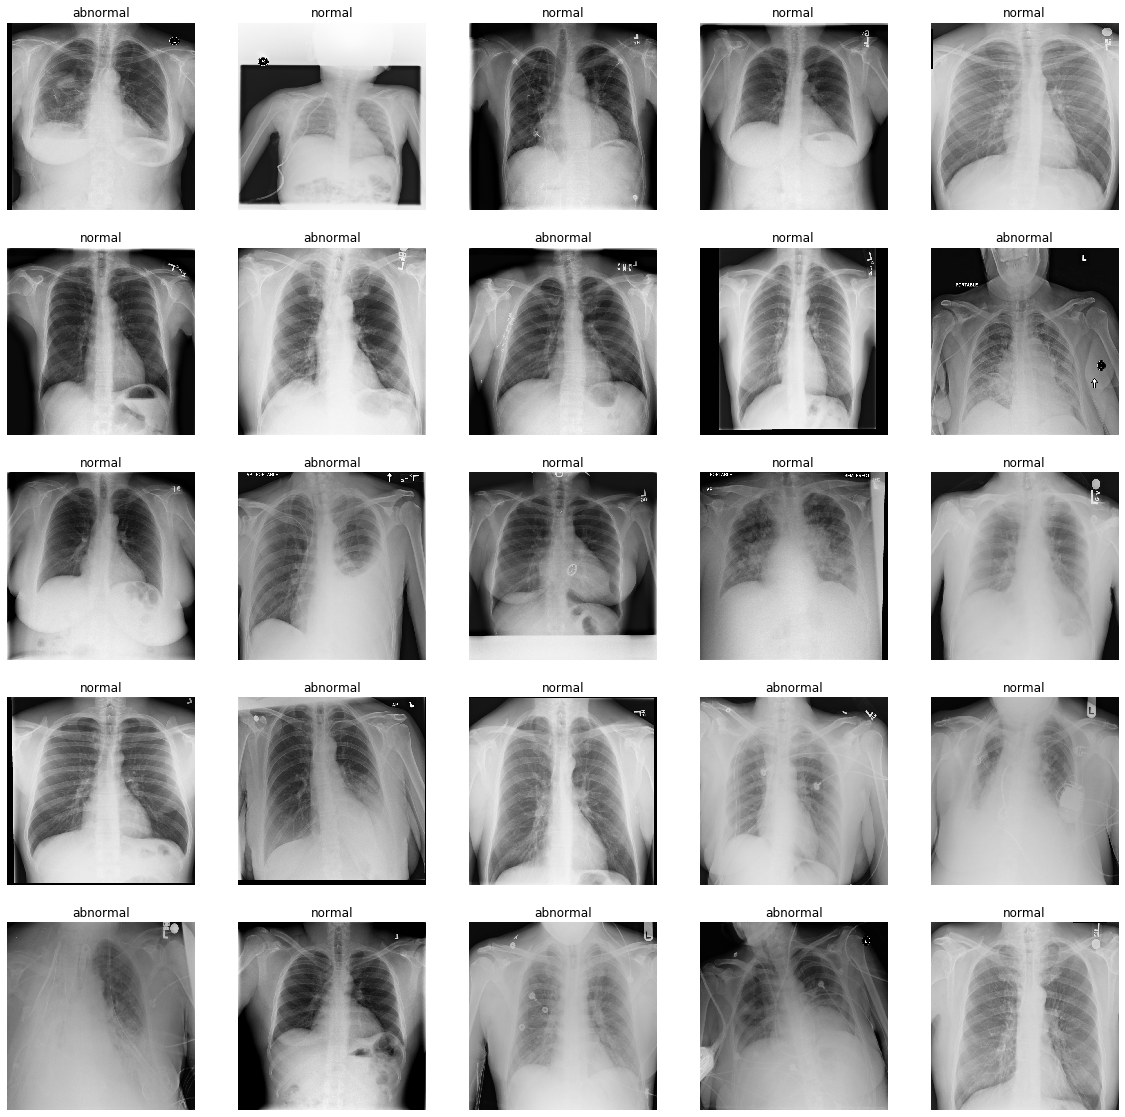

In [4]:
parser.visualize_random_images(25, display_label=True)

It is necessary to look at the number of samples pertaining to each class. Hence, if there is severe disparity, certain sampling methods can be used for better learning. The `explore_class_imbalance` method helps in identifying class imbalance.

normal : 3044
abnormal : 2562
Imbalance not detected


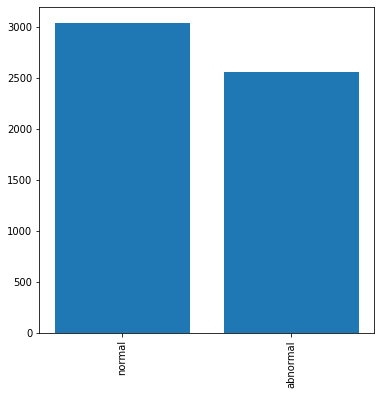

In [5]:
parser.explore_class_imbalance()

## Training a neural network

The classes seem balanced. We can now move on to training a simple VGG-style neural network for 2-class classification. 

First let's create Data generators for loading and working with the data. For this, load the necessary labels dataframe created by our parser using `get_labels_df` method.


In [6]:
df = parser.get_labels_df()
df.head()

Id Label
0  00000013_005.png     1
1  00000013_026.png     1
2  00000017_001.png     0
3  00000030_001.png     1
4  00000032_001.png     1

Let's divide the dataframe into train and val using `train_test_split` method from `scikit-learn`.
Note that ideally a test set also needs to be extracted which we shall omit here as this is just a simple walkthrough.

In [7]:
"""Dividing dataset into train and val for validation later"""

train, val = train_test_split(df, test_size=0.2, random_state=42, shuffle = True, stratify=df['Label'])

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

print("Found {} samples for training".format(len(train)))
print("Found {} samples for validation".format(len(val)))

Found 4484 samples for training
Found 1122 samples for validation


We now create data generators for the datasets that we created. We also use certain transformations for the train dataset as it will help build a robust classification model.

In [11]:
"""Creating train and val generator"""
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True, 
                                   vertical_flip = False, 
                                   height_shift_range= 0.05, 
                                   width_shift_range=0.1, 
                                   rotation_range=5, 
                                   shear_range = 0.1,
                                   fill_mode = 'reflect',
                                   zoom_range=0.15)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images',
        x_col="Id",
        y_col="Label",
        batch_size=64,
        target_size=(128,128),
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val,
        directory='C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images',
        x_col="Id",
        y_col="Label",
        batch_size=64,
        target_size=(128,128),
        class_mode='binary')


Found 5606 validated image filenames belonging to 2 classes.
Found 1122 validated image filenames belonging to 2 classes.


Let's visualize an image generated by our train data generator.

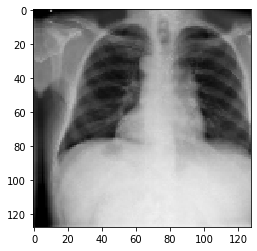

In [12]:
plt.imshow(train_generator[0][0][5])

### Defining the model
Here we define a VGG-style neural network for classification. We use Adam as the optimizer and Sigmoid as the final layer activation function. Binary cross-entropy loss is used for calculating loss for backprop.

In [13]:
"""Defining model"""

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(2, 2)) 
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

#define optimizer
opt = Adam(lr=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Let's train the model for 10 epochs!

In [14]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.0001, verbose=1),
]

train_steps = int(len(train)/64)
val_steps = int(len(val)/64)
model.fit_generator(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
70/70 [==============================] - 345s 5s/step - loss: 0.7428 - accuracy: 0.5564 - val_loss: 0.6583 - val_accuracy: 0.6103
Epoch 2/10
70/70 [==============================] - 346s 5s/step - loss: 0.6700 - accuracy: 0.5977 - val_loss: 0.6455 - val_accuracy: 0.6278
Epoch 3/10
70/70 [==============================] - 319s 5s/step - loss: 0.6764 - accuracy: 0.5754 - val_loss: 0.6698 - val_accuracy: 0.5597
Epoch 4/10
70/70 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.5862
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
70/70 [==============================] - 348s 5s/step - loss: 0.6724 - accuracy: 0.5862 - val_loss: 0.6670 - val_accuracy: 0.6241
Epoch 5/10
70/70 [==============================] - 334s 5s/step - loss: 0.6629 - accuracy: 0.6136 - val_loss: 0.6484 - val_accuracy: 0.6121
Epoch 6/10
70/70 [==============================] - ETA

### Visualizing loss and accuracy curves
Let's take a look at the loss and accuracy curves of our trained model. We can then identify important points, for example, where the model started to overfit, etc.

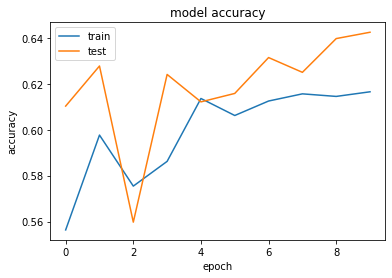

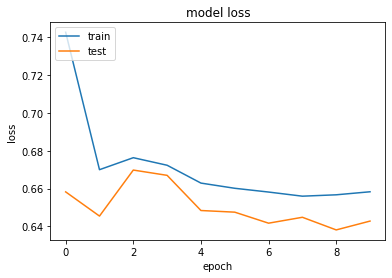

In [15]:
"""Visualize learning curve"""
history = model.history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transfer learning
Now let's use an InceptionResnet model pretrained on ImageNet and see how it performs. We freeze the layers of the model and append a mini-network of fully connected layers which we shall train.

Let's train the model for 5 epochs and visualize the learning curves

In [16]:
"""Defining model"""

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for i, layer in enumerate(model.layers[-11:]):
    print(i, layer.name)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

219062272/219055592 [==============================] - 27s 0us/step
0 global_average_pooling2d
1 dense_2
2 batch_normalization_203
3 dropout
4 dense_3
5 batch_normalization_204
6 dropout_1
7 dense_4
8 batch_normalization_205
9 dropout_2
10 dense_5


In [17]:
train_steps = int(len(train)/64)
val_steps = int(len(val)/64)
model.fit_generator(train_generator,
        steps_per_epoch=train_steps,
        epochs=5,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=val_steps,
        verbose=1)

Epoch 1/5
70/70 [==============================] - 233s 3s/step - loss: 0.7785 - accuracy: 0.5775 - val_loss: 1.0914 - val_accuracy: 0.6112
Epoch 2/5
70/70 [==============================] - 246s 4s/step - loss: 0.7046 - accuracy: 0.6004 - val_loss: 0.7387 - val_accuracy: 0.5671
Epoch 3/5
70/70 [==============================] - 266s 4s/step - loss: 0.6814 - accuracy: 0.6226 - val_loss: 0.6189 - val_accuracy: 0.6599
Epoch 4/5
70/70 [==============================] - 274s 4s/step - loss: 0.6660 - accuracy: 0.6322 - val_loss: 0.6305 - val_accuracy: 0.6581
Epoch 5/5
70/70 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.6221
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
70/70 [==============================] - 229s 3s/step - loss: 0.6649 - accuracy: 0.6221 - val_loss: 0.6381 - val_accuracy: 0.6645


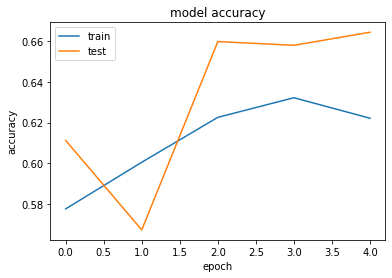

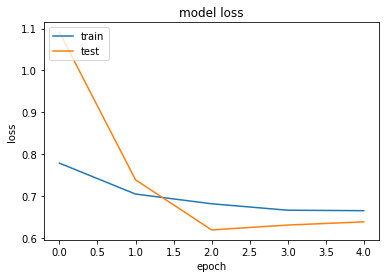

In [18]:
"""Visualize learning curve"""
history = model.history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<div id="Multilabel"></div>

# Multilabel classification
We now create a parser for multilabel classification as an instance of DatasetParser. We set the `task_type` parameter to "multilabel" for multilabel classification.

In [22]:
parser = DatasetParser(root_dir="C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample",
                       images_dir="sample/images",
                       labels_csv="sample_labels.csv",
                       task_type="multilabel"
                      )

#C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/

## Visualization and exploration
Let's visualize 25 random images from the dataset.

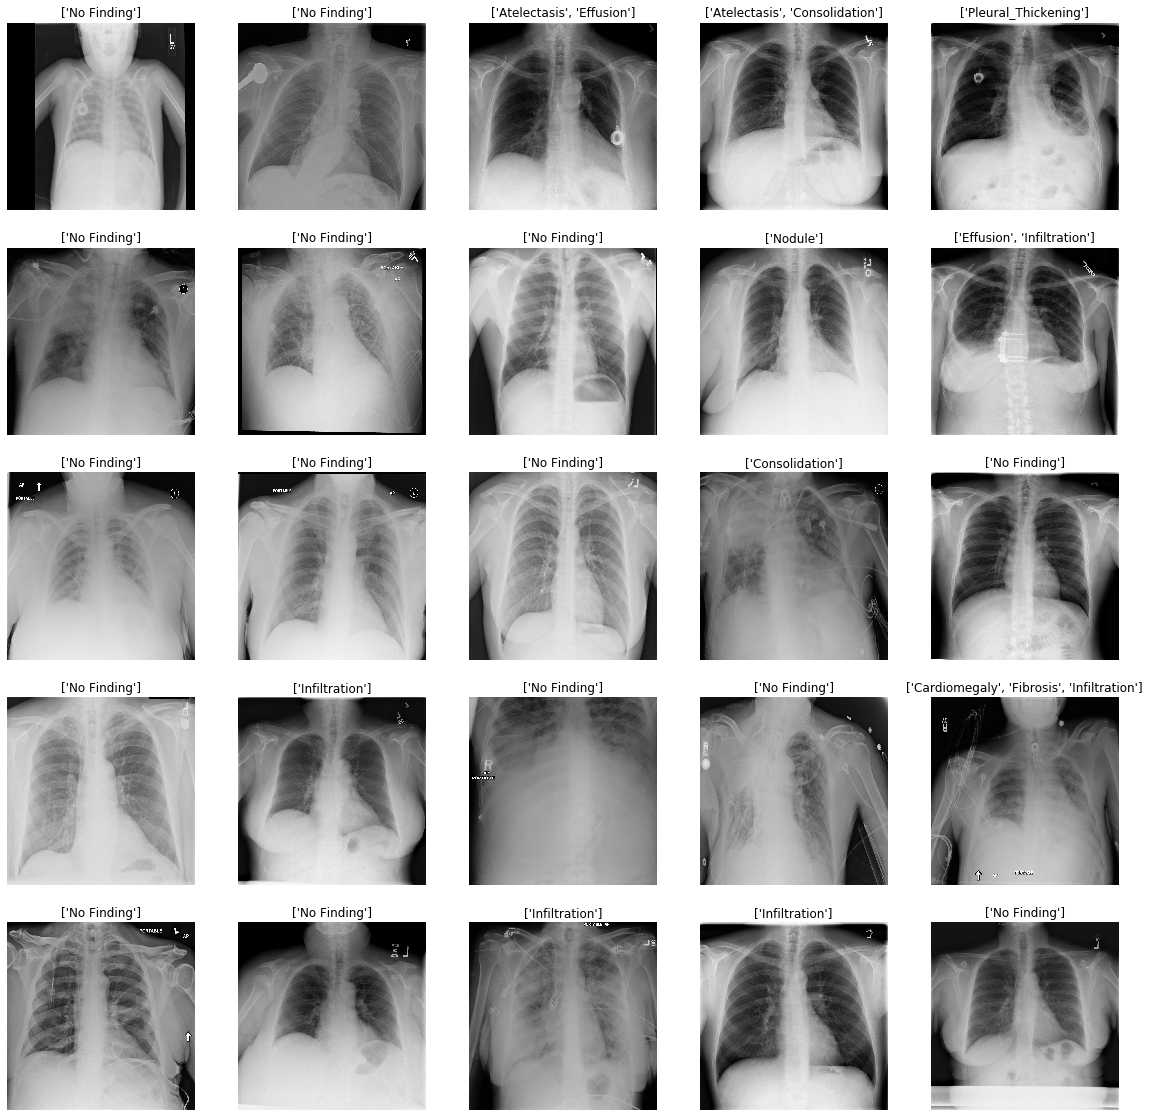

In [23]:
parser.visualize_random_images(25, display_label=True)

Let's also visualize some images from the "Hernia" class as it has the least number of samples(13).

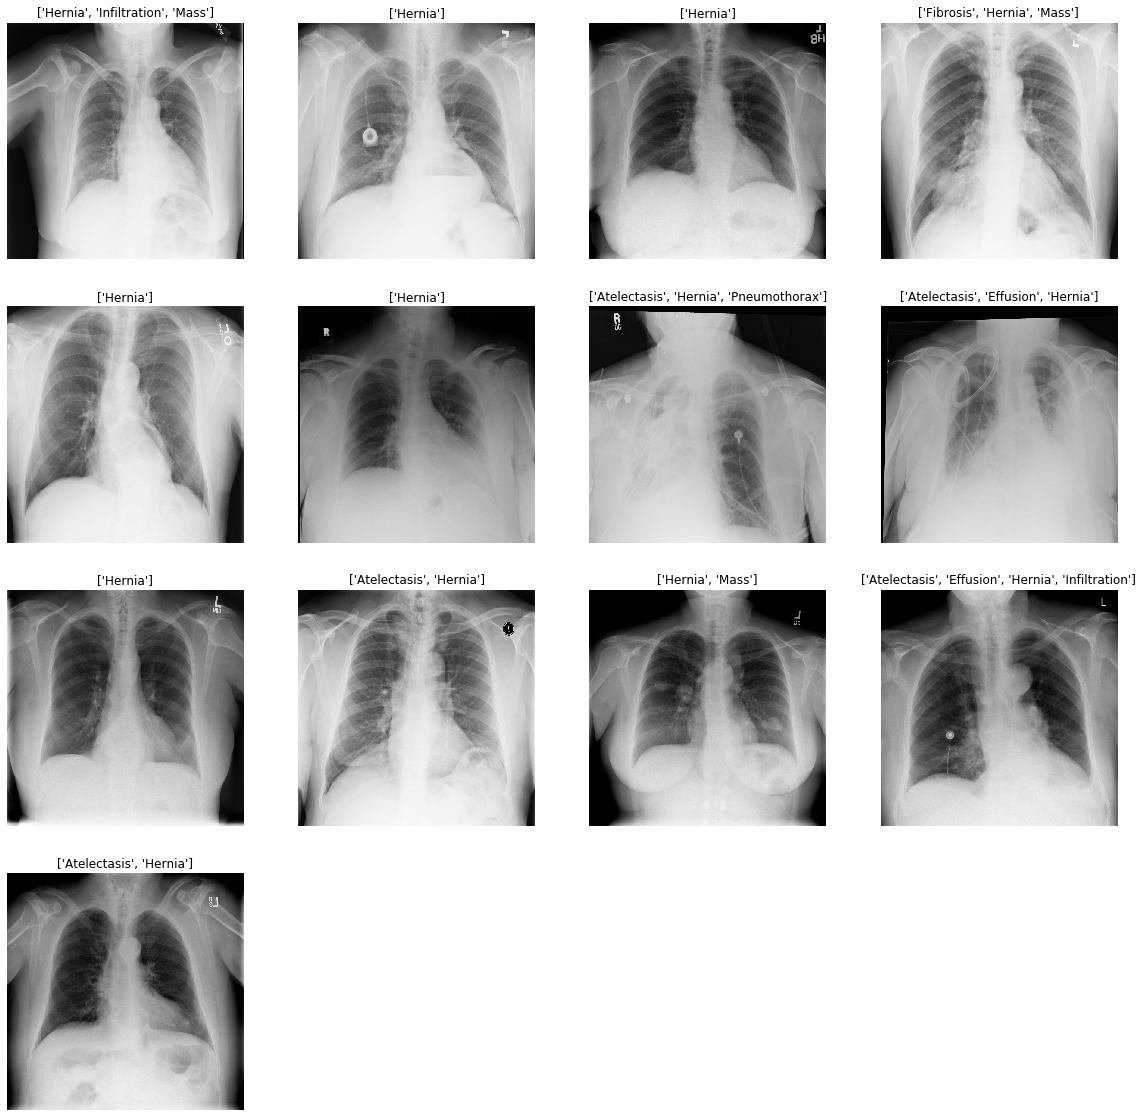

In [24]:
parser.visualize_random_images(25, label='Hernia', display_label=True)

Let's explore class imbalance using the `explore_class_imbalance` method.

Cardiomegaly : 141
Emphysema : 127
Effusion : 644
Hernia : 13
Nodule : 313
Pneumothorax : 271
Atelectasis : 508
Pleural_Thickening : 176
Mass : 284
Edema : 118
Consolidation : 226
Infiltration : 967
Fibrosis : 84
Pneumonia : 62
No Finding : 3044
Imbalance detected


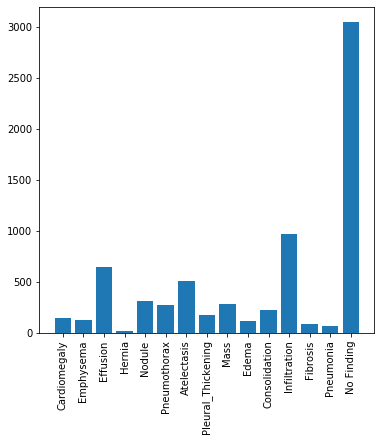

In [25]:
parser.explore_class_imbalance()

As is pointed by the parser the dataset suffers from severe class imbalance. Let's first however try to build a model using the imbalanced classes so that we can compare the results of this with that of balanced classes later.

## Working with imbalanced classes
First let's load the dataframe and split the dataset into train and validation.

In [26]:
df = parser.labels_df
df.head()

Id                                              Label
0  00000013_005.png  [Emphysema, Infiltration, Pleural_Thickening, ...
1  00000013_026.png                          [Cardiomegaly, Emphysema]
2  00000017_001.png                                       [No Finding]
3  00000030_001.png                                      [Atelectasis]
4  00000032_001.png                    [Cardiomegaly, Edema, Effusion]

Let's split the data into train and validation sets and also create the data generators for the same.

In [27]:
"""Dividing dataset into train and val for validation later"""

train, val = train_test_split(df, test_size=0.2, random_state=42, shuffle = True)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

print("Found {} samples for training".format(len(train)))
print("Found {} samples for validation".format(len(val)))

Found 4484 samples for training
Found 1122 samples for validation


In [31]:
"""Creating train and val generator"""
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True, 
                                   vertical_flip = False, 
                                   height_shift_range= 0.05, 
                                   width_shift_range=0.1, 
                                   rotation_range=5, 
                                   shear_range = 0.1,
                                   fill_mode = 'reflect',
                                   zoom_range=0.15)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images',
        x_col="Id",
        y_col="Label",
        batch_size=64,
        target_size=(128,128),
        classes = parser.labels,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val,
        directory='C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images',
        x_col="Id",
        y_col="Label",
        batch_size=64,
        target_size=(128,128),
        classes = parser.labels,
        class_mode='categorical')

Found 5606 validated image filenames belonging to 15 classes.
Found 1122 validated image filenames belonging to 15 classes.


Let's use a pretrained MobileNet model to create our classifier. As before, use sigmoid as the final layer function and adam as the optimizer.

In [33]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

base_mobilenet_model = MobileNet(input_shape = train_generator[0][0].shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(parser.labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)                7695      
Total params: 3,761,359
Trainable params: 3,739,471
Non-trainable params: 21,888
_______________________________________

In [34]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.0001, verbose=1),
]

train_steps = int(len(train)/64)
val_steps = int(len(val)/64)
multi_disease_model.fit_generator(train_generator,
        steps_per_epoch=train_steps,
        epochs=5,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=val_steps,
        verbose=1)

Epoch 1/5
70/70 [==============================] - 319s 5s/step - loss: 0.3110 - binary_accuracy: 0.9060 - mae: 0.1264 - val_loss: 0.2859 - val_binary_accuracy: 0.9222 - val_mae: 0.2183
Epoch 2/5
70/70 [==============================] - 325s 5s/step - loss: 0.2375 - binary_accuracy: 0.9205 - mae: 0.1209 - val_loss: 0.2224 - val_binary_accuracy: 0.9224 - val_mae: 0.1038
Epoch 3/5
70/70 [==============================] - 354s 5s/step - loss: 0.2245 - binary_accuracy: 0.9228 - mae: 0.1179 - val_loss: 0.2543 - val_binary_accuracy: 0.9167 - val_mae: 0.0924
Epoch 4/5
70/70 [==============================] - ETA: 0s - loss: 0.2218 - binary_accuracy: 0.9243 - mae: 0.1190
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
70/70 [==============================] - 352s 5s/step - loss: 0.2218 - binary_accuracy: 0.9243 - mae: 0.1190 - val_loss: 0.2628 - val_binary_accuracy: 0.9172 - val_mae: 0.0887
Epoch 5/5
70/70 [==============================] - 332s 5s/step - loss:

We now visualize the loss and accuracy curves for this model. We will also need to look at the AUC-ROC curve to signify class imbalance.

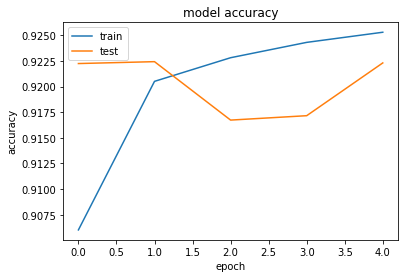

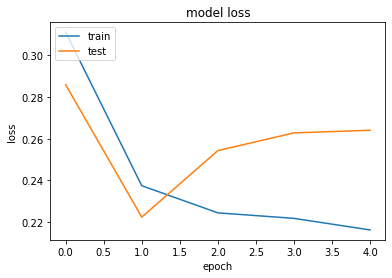

In [35]:
"""Visualize learning curve"""
history = multi_disease_model.history

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's test the model on the validation set (Not creating a new test set). 

In [37]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=val,
        directory='C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images',
        x_col="Id",
        batch_size=1,
        target_size=(128,128),
        shuffle=False,
        class_mode=None)

test_generator.reset()
pred = multi_disease_model.predict_generator(test_generator, steps=len(val), verbose=1)

Found 1122 validated image filenames.
1122/1122 [==============================] - 24s 22ms/step


We now create a one-hot encoded array for the validation dataset so that we can plot the AUC-ROC curve.

In [38]:
new_labels_df = val.copy()
        
onehot_arr = np.zeros((len(val),len(parser.labels)))
for i in range(len(new_labels_df)):
    for element in new_labels_df['Label'][i]:
        onehot_arr[i,parser.labels.index(element)] = 1
        
print(onehot_arr.shape == pred.shape)

True


Let's visualize some images with confidence scores for the respective classes.

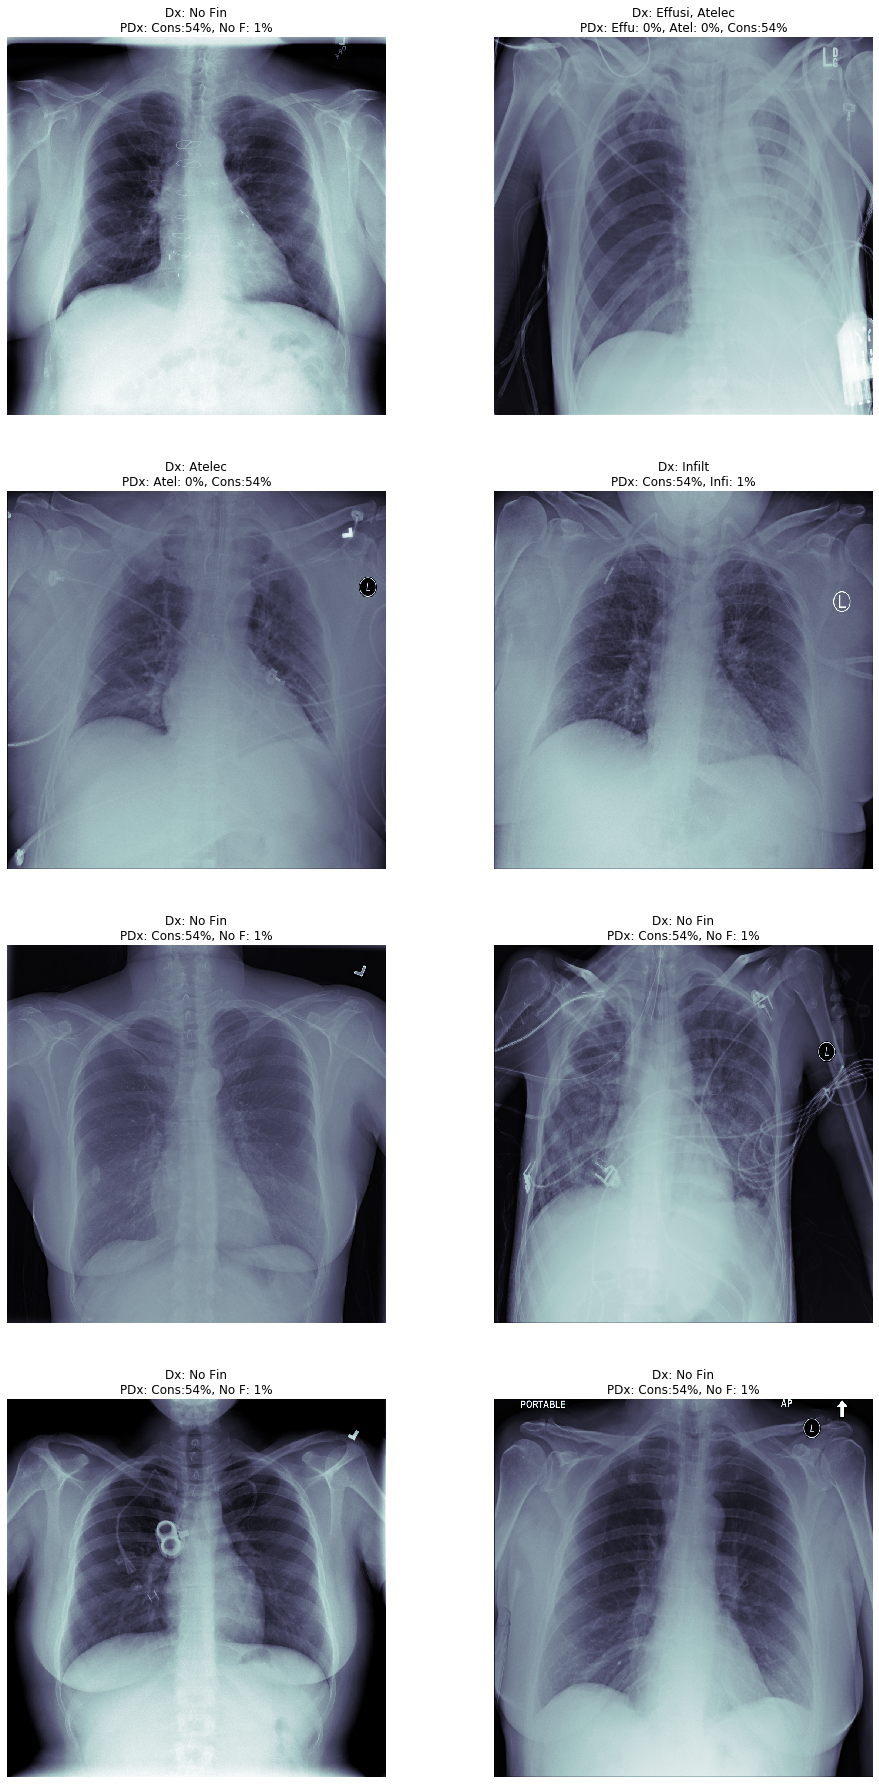

In [42]:
sickest_idx = np.argsort(np.sum(onehot_arr, 1)<1)

fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    img = plt.imread("C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/sample/images/" + val['Id'][idx])
    c_ax.imshow(img, cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(parser.labels,onehot_arr[idx]) if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(parser.labels, 
                onehot_arr[idx], pred[idx]) if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
    

This is not a very impressive result. Let's plot the AUC-ROC curve to gain more insights.

### AUC-ROC curve
Let's plot the AUC-ROC curve for the test labels and see how well the model distinguishes between the different classes. 

Text(0, 0.5, 'True Positive Rate')

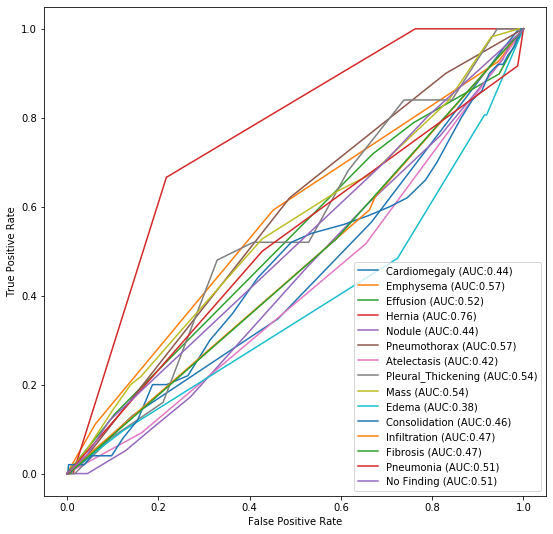

In [43]:
from sklearn.metrics import roc_curve, auc

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(parser.labels):
    fpr, tpr, thresholds = roc_curve(onehot_arr[:,idx].astype(int), pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

From the ROC curve we can find that the AUC for almost all the categories is less than or around 0.5, i.e., the model cannot properly distinguish between these classes. This is obvious as the classes are heavily imbalanced.

## Sampling based on number of classes
Let's sample datapoints based on the number of classes they represent. As such, there will be less bias and more representation can be seen. We can sample datapoints using the `sample` method of the parser. We set the `is_weighted` parameter to `True` to allow weighted sampling.

In [44]:
df = parser.sample(3000, is_weighted=True)

df.head()

Id                                  Label
250   00001338_002.png                         [Infiltration]
1341  00006996_004.png  [Atelectasis, Effusion, Infiltration]
2190  00011328_004.png                           [No Finding]
2396  00012087_042.png               [Fibrosis, Infiltration]
4130  00020326_009.png                  [Edema, Infiltration]

In [45]:
"""Dividing dataset into train and val for validation later"""

train, val = train_test_split(df, test_size=0.2, random_state=42, shuffle = True)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

print("Found {} samples for training".format(len(train)))
print("Found {} samples for validation".format(len(val)))

"""Creating train and val generator"""
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True, 
                                   vertical_flip = False, 
                                   height_shift_range= 0.05, 
                                   width_shift_range=0.1, 
                                   rotation_range=5, 
                                   shear_range = 0.1,
                                   fill_mode = 'reflect',
                                   zoom_range=0.15)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images',
        x_col="Id",
        y_col="Label",
        batch_size=64,
        target_size=(128,128),
        classes = parser.labels,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val,
        directory='C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images',
        x_col="Id",
        y_col="Label",
        batch_size=64,
        target_size=(128,128),
        classes = parser.labels,
        class_mode='categorical')

Found 2400 samples for training
Found 600 samples for validation
Found 3000 validated image filenames belonging to 15 classes.
Found 600 validated image filenames belonging to 15 classes.


Let's train the model with the newly sampled data.

In [47]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

base_mobilenet_model = MobileNet(input_shape = train_generator[0][0].shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(parser.labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                7695      
Total params: 3,761,359
Trainable params: 3,739,471
Non-trainable params: 21,888
_______________________________________

In [48]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.0001, verbose=1),
]

train_steps = int(len(train)/64)
val_steps = int(len(val)/64)
multi_disease_model.fit_generator(train_generator,
        steps_per_epoch=train_steps,
        epochs=10,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=val_steps,
        verbose=1)

Epoch 1/10
37/37 [==============================] - 169s 5s/step - loss: 0.3715 - binary_accuracy: 0.8838 - mae: 0.1501 - val_loss: 0.4812 - val_binary_accuracy: 0.9073 - val_mae: 0.3747
Epoch 2/10
37/37 [==============================] - 201s 5s/step - loss: 0.2988 - binary_accuracy: 0.9028 - mae: 0.1435 - val_loss: 0.2899 - val_binary_accuracy: 0.9104 - val_mae: 0.2153
Epoch 3/10
37/37 [==============================] - 174s 5s/step - loss: 0.2859 - binary_accuracy: 0.9036 - mae: 0.1448 - val_loss: 0.2521 - val_binary_accuracy: 0.9100 - val_mae: 0.1535
Epoch 4/10
37/37 [==============================] - 168s 5s/step - loss: 0.2700 - binary_accuracy: 0.9082 - mae: 0.1411 - val_loss: 0.2521 - val_binary_accuracy: 0.9104 - val_mae: 0.1181
Epoch 5/10
37/37 [==============================] - ETA: 0s - loss: 0.2630 - binary_accuracy: 0.9103 - mae: 0.1391
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
37/37 [==============================] - 161s 4s/step - 

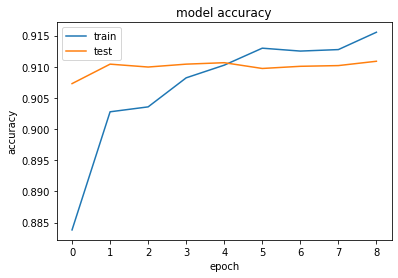

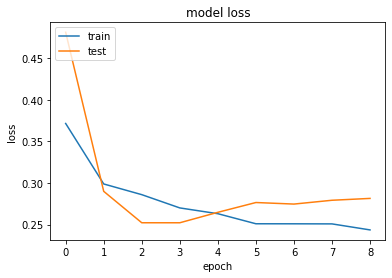

In [49]:
"""Visualize learning curve"""
history = multi_disease_model.history

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=val,
        directory='C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images',
        x_col="Id",
        batch_size=1,
        target_size=(128,128),
        shuffle=False,
        class_mode=None)

test_generator.reset()
pred = multi_disease_model.predict_generator(test_generator, steps=len(val), verbose=1)

new_labels_df = val.copy()
        
onehot_arr = np.zeros((len(val),len(parser.labels)))
for i in range(len(new_labels_df)):
    for element in new_labels_df['Label'][i]:
        onehot_arr[i,parser.labels.index(element)] = 1
        
print(onehot_arr.shape == pred.shape)

Found 600 validated image filenames.
600/600 [==============================] - 14s 24ms/step
True


### AUC-ROC Curve
Let's plot the AUC-ROC curve for this model

Text(0, 0.5, 'True Positive Rate')

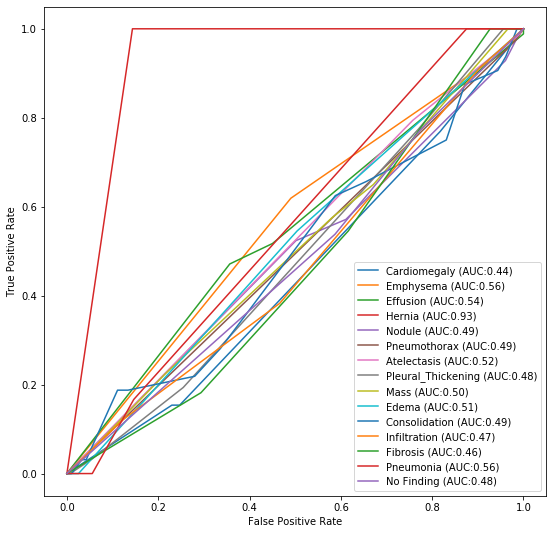

In [52]:
from sklearn.metrics import roc_curve, auc

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(parser.labels):
    fpr, tpr, thresholds = roc_curve(onehot_arr[:,idx].astype(int), pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

## Visualize test images with confidence scores
Let's visualize some images with their confidence scores of respective labels.

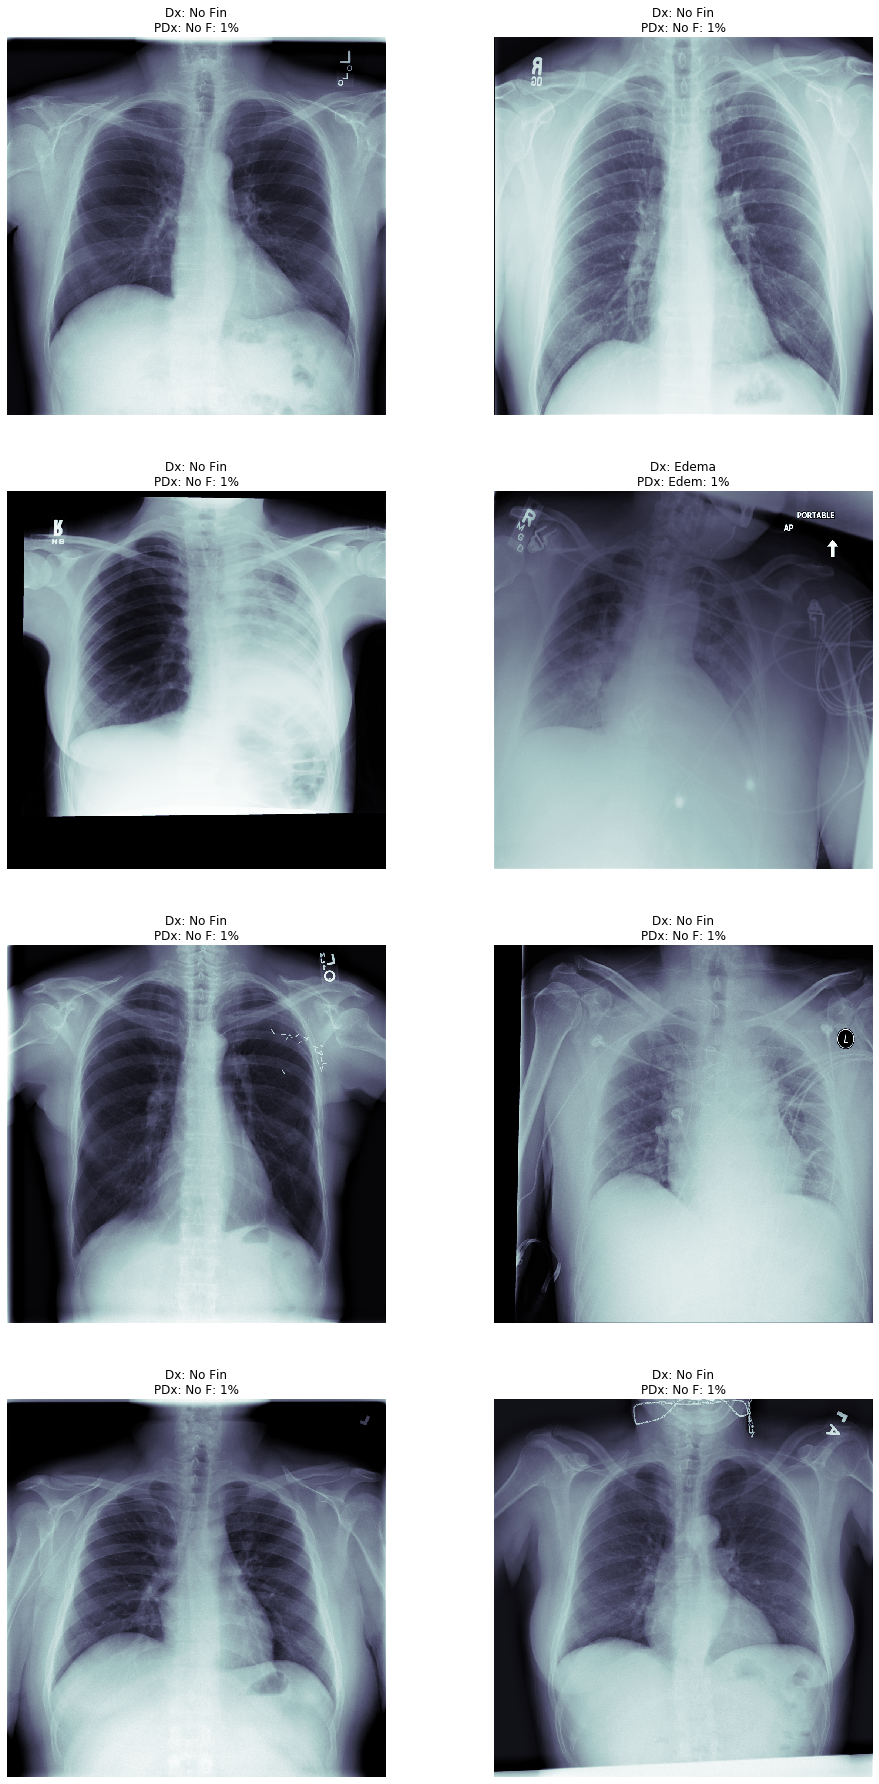

In [55]:
sickest_idx = np.argsort(np.sum(onehot_arr, 1)<1)

fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    img = plt.imread("C:/Users/SONALIMP/Desktop/JNBOOK/KrishNaik/MLTutorials/input/sample/images/" + val['Id'][idx])
    c_ax.imshow(img, cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(parser.labels,onehot_arr[idx]) if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(parser.labels, 
                onehot_arr[idx], pred[idx]) if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
    

As is evident from the images and confidence scores above, the model is actually able to predict the actual class with certain confidence unlike before. Hence, this model using weighted sampled datapoints actually improves over the previous model.